### Topic 1: Structural Properties of LADs
# Similarities between cells

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/1_Preimplantation.structural_properties_of_LADs.part2b.similarities_between_cells.heterozygous/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']
treatment_order = ['no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['construct'] == 'Lmnb1'].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno['treatment'].isin(treatment_order)]
anno = anno[anno.cellcount == 1]
anno = anno[anno.is_heterozygous]

# setting stage order
anno['stage_order'] = anno['stage'].apply(func=lambda s: {stage: i for i, stage in enumerate(stage_order)}[s])
anno['stage'] = pd.Categorical(anno['stage'], categories=stage_order)
anno = anno.set_index(anno['damid_name'])

anno.head()

,runid,illumina_index,damid2_adapter_number,celseq2_adapter_number,cellcount,construct,fusion_construct,stage,treatment,genotype,...,nTranscripts,nTranscripts_maternal,nTranscripts_paternal,allelic_celseq_balance,nERCC,nMito,DamID_PASS,DamID_PASS_allelic,CELseq_PASS,stage_order
damid_name,,,,,,,,,,,,,,,,,,,,,
KIN6284.index01.DamID2_BC_001,KIN6284,1,1,1,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,32445,6140.0,6715.0,True,10,780,True,True,True,3
KIN6284.index01.DamID2_BC_002,KIN6284,1,2,2,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,1912,241.0,200.0,True,63,105,True,True,False,3
KIN6284.index01.DamID2_BC_003,KIN6284,1,3,3,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,26216,4466.0,5480.0,True,45,1069,True,True,True,3
KIN6284.index01.DamID2_BC_004,KIN6284,1,4,4,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,16230,2642.0,3172.0,True,16,613,True,True,True,3
KIN6284.index01.DamID2_BC_005,KIN6284,1,5,5,1,Lmnb1,Dam-Lmnb1,mESC,no_treatment,129S1/SvImJ_x_CAST/EiJ,...,7235,1111.0,1367.0,True,28,369,True,True,True,3


## 1.2 Loading mappability

In [8]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [9]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [10]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__DamID sample counts__

In [11]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined


__DamID sample binary signal__

In [12]:
damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined


__Contact Frequency__

In [13]:
if BINSIZE >= 100000:
    contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

        # load combined
        gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
        name = (info[1], info[2], info[3])

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        contact_freq['combined'][name] =  load_count_file(fn)

        if info[-1]:
            for parent, gt in GENOTYPE2PARENT[info[2]].items():
                gt_name = info[2].replace('/','') + '.' + gt
                fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
                contact_freq[parent][name] =  load_count_file(fn)

## 1.4 Loading allele visibility

In [14]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# CF as a measure of variability

In [15]:
chrom_select = np.array(chrom_order[:-2])
m_ind = np.concatenate([mapab[c] for c in chrom_select]) > MINMAP

to_plot = list()

for info, df in anno.groupby(['stage', 'genotype', 'treatment']):
    a_filt = np.concatenate([allele_filt_gt[info[1]][c] for c in chrom_order[:-2]])
        
    for allele in ['combined', 'maternal', 'paternal']:
        
        cf = np.concatenate([contact_freq[allele][info][c] for c in chrom_order[:-2]])
        filt = m_ind if allele == 'combined' else m_ind&a_filt
        cf = cf[filt]
        n = len(cf)
        

        out = pd.DataFrame({
            'stage': np.repeat(info[0],n), 
            'genotype': np.repeat(info[1], n),
            'treatment': np.repeat(info[2],n),
            'allele': np.repeat(allele, n),
            'cf': cf
        })
        to_plot.append(out)
        
to_plot = pd.concat(to_plot, axis=0)
to_plot['label'] = to_plot.apply(axis=1, func = lambda r: '%s - %s\n%s' % (r['stage'], r['treatment'], r['genotype']))
to_plot['label2'] = to_plot.apply(axis=1, func = lambda r: '%s\n%s' % (r['stage'], r['treatment']))


In [16]:
from collections import defaultdict

/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_4180/1850889628.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)


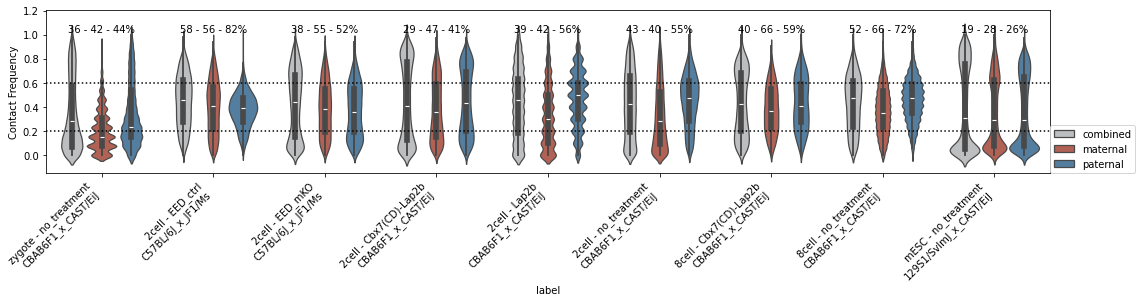

In [17]:
T1 = 0.2
T2 = 0.6

order = to_plot['label'].unique()

fig, ax = plt.subplots(1,1, figsize=(len(order)*2,3))

ho = ['combined', 'maternal', 'paternal']
sns.violinplot(
    x=to_plot['label'], 
    y=to_plot['cf'], 
    hue=to_plot['allele'],
    order=order, palette=color_dict['allele'], ax=ax, hue_order=ho
)

ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.legend(loc=(1,0))
ax.axhline(T1, c='k', ls=':')
ax.axhline(T2, c='k', ls=':')
ax.set_ylabel('Contact Frequency')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.05)

info_ls = defaultdict(list)
    
for x, lab in enumerate(order):
    t = list()
    
    for allele in ho:
        df = to_plot[(to_plot['label']==lab) & (to_plot['allele'] == allele)]
        p = ((df.cf > T1) & (df.cf <= T2)).mean() * 100
        t.append(p)
        
        # collect info
        for i in range(3):
            if i == 0:
                p = (df.cf <= T1).mean()*100
                l = 'low'
            elif i == 1:
                p = ((df.cf > T1) & (df.cf <= T2)).mean() * 100
                l = 'mid'
            else:
                p = (df.cf > T2).mean()*100
                l = 'high'
            info_ls['sample'].append(lab)
            info_ls['allele'].append(allele)
            info_ls['n_bins'].append(len(df))
            info_ls['cf_level'].append(l)
            info_ls['pct_genome'].append(p)
    
    t = '{:.0f} - {:.0f} - {:.0f}%'.format(t[0], t[1], t[2])
    ax.text(x, 1, t, ha='center', va='bottom')
    
outfn = FIGOUTDIR + 'contact_frequency_distribution.as_measure_of_variability.all_conditions.pdf'
plt.savefig(outfn)

In [18]:
df = pd.DataFrame(info_ls)
df[df['sample'].str.contains('EED') & (df['allele'] =='paternal')]

,sample,allele,n_bins,cf_level,pct_genome
15,2cell - EED_ctrl\nC57BL/6J_x_JF1/Ms,paternal,20715,low,13.019551
16,2cell - EED_ctrl\nC57BL/6J_x_JF1/Ms,paternal,20715,mid,81.762008
17,2cell - EED_ctrl\nC57BL/6J_x_JF1/Ms,paternal,20715,high,5.218441
24,2cell - EED_mKO\nC57BL/6J_x_JF1/Ms,paternal,20715,low,29.867246
25,2cell - EED_mKO\nC57BL/6J_x_JF1/Ms,paternal,20715,mid,52.454743
26,2cell - EED_mKO\nC57BL/6J_x_JF1/Ms,paternal,20715,high,17.678011


/var/folders/f6/njqy731d5qzd2j0713w49f2jrtp6zr/T/ipykernel_65759/2691044401.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)


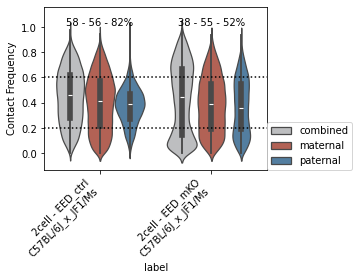

In [36]:
T1 = 0.2
T2 = 0.6

to_plot2 = to_plot[(to_plot.stage=='2cell')&(to_plot['treatment'].str.contains('EED'))].copy()

order = to_plot2['label'].unique()

fig, ax = plt.subplots(1,1, figsize=(len(order)*2,3))

ho = ['combined', 'maternal', 'paternal']
sns.violinplot(
    x=to_plot2['label'], 
    y=to_plot2['cf'], 
    hue=to_plot2['allele'],
    order=order, palette=color_dict['allele'], ax=ax, hue_order=ho
)

ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
ax.legend(loc=(1,0))
ax.axhline(T1, c='k', ls=':')
ax.axhline(T2, c='k', ls=':')
ax.set_ylabel('Contact Frequency')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], ylim[1]+.05)
    
for x, lab in enumerate(order):
    t = list()
    
    for allele in ho:
        df = to_plot2[(to_plot2['label']==lab) & (to_plot2['allele'] == allele)]
        p = ((df.cf > T1) & (df.cf < T2)).mean() * 100
        t.append(p)
    
    t = '{:.0f} - {:.0f} - {:.0f}%'.format(t[0], t[1], t[2])
    ax.text(x, 1, t, ha='center', va='bottom')
    
outfn = FIGOUTDIR + 'contact_frequency_distribution.as_measure_of_variability.EED_conditions.pdf'
plt.savefig(outfn)

# 3. Variability in specific regions

## 3.1 Load different genome segmentations

### cLADs, ciLADs and fLADs/fiLADs based on Peric-Hupkes

In [17]:
# load LAD calls
FN = '../../GSE17051/data/SaraPerricone_Peric-Hupkes2010.HMM_state_aver_repl_100kb_bins.mm10.txt'
perichupkes = pd.read_table(FN)
perichupkes.columns = ['chrom', 'start', 'end', 'AC', 'ESC', 'MEF', 'NPC']
for col in ['AC', 'ESC', 'MEF', 'NPC']:
    perichupkes.loc[perichupkes[col].str.contains('NA'), col] = np.nan
    perichupkes[col] = perichupkes[col].astype(float)
perichupkes['chrom'] = perichupkes['chrom'].apply(func = lambda c: c.strip('chr'))
perichupkes = perichupkes[perichupkes.chrom.isin(chrom_order)]

# determine cLAD/ciLAD/fLAD
perichupkes['is_valid'] = perichupkes.isna().sum(axis=1) == 0
perichupkes.loc[~perichupkes.is_valid, 'LAD_type'] = 'invalid'
perichupkes.loc[perichupkes.is_valid, 'LAD_type'] = 'fLAD/fiLAD'
ind = perichupkes[['AC', 'ESC', 'MEF', 'NPC']].sum(axis=1) == 4
perichupkes.loc[ind, 'LAD_type'] = 'cLAD'
ind = (perichupkes[['AC', 'ESC', 'MEF', 'NPC']].sum(axis=1) == 0) & (perichupkes.is_valid)
perichupkes.loc[ind, 'LAD_type'] = 'ciLAD'

__Convert to arrays matching chromosome lengths__

In [18]:
lad_type_ph = dict()

for chrom, df in perichupkes.groupby('chrom'):
    assert(all(df.end.values[:-1] == df.start.values[1:]))
    assert len(df) >= len(mapab[chrom])
    
    l = df['LAD_type'].values
    lad_type_ph[chrom] = l[:len(mapab[chrom])]

### H3K27me3 in the 2-cell embryo

In [19]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment == 'no']

samples = ext_anno.loc[ext_anno.target.isin(['H3K27me3']), 'sample_id'].values
controls = ext_anno.loc[ext_anno.sample_id.isin(samples) & (ext_anno.control_id != 'none'), 'control_id'].values
samples = np.concatenate([samples, controls])
ext_anno = ext_anno[ext_anno.sample_id.isin(samples)]
ext_anno = ext_anno[~((ext_anno.dataset_id == 'GSE71434') & (ext_anno.target == 'H3K27me3'))]

select_stages = [
    'PN3_zygote', 'PN5_zygote', 
    '2cell_early', '2cell', '2cell_late',
    '8cell', 'mESC'
]
ext_anno = ext_anno[ext_anno.stage.isin(select_stages)]

ext_anno['stage'] = pd.Categorical(ext_anno['stage'], select_stages)

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [20]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: data[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: data[c][:len(mapab[c])] for c in chrom_order}

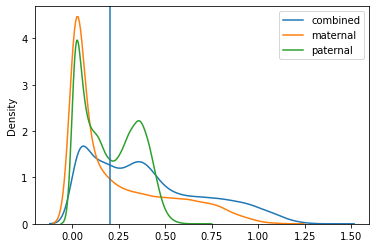

In [21]:
ext_sample = 'GSE76687_008'

fig, ax = plt.subplots()

vis_ind = np.concatenate([ext_data['allele_vis'][ext_sample][c] for c in chrom_order]) > .4
for parent in ['combined', 'maternal', 'paternal']:
    x = np.concatenate([ext_data[parent][ext_sample][c] for c in chrom_order])[vis_ind]
    sns.kdeplot(x.clip(0,1.5), label=parent)
ax.legend()
ax.axvline(.2)

In [22]:
a = np.concatenate([ext_data['maternal'][ext_sample][c] for c in chrom_order])[vis_ind] > .2
b = np.concatenate([ext_data['paternal'][ext_sample][c] for c in chrom_order])[vis_ind] > .2
c = np.concatenate([ext_data['combined'][ext_sample][c] for c in chrom_order])[vis_ind] > .2

print(a.sum())
print(b.sum())
print((a&b).sum(), (a&b).mean())
print((a|b).sum())
print(((a|b) & c).sum())
print(c.sum())

8736
10545
5610 0.2538576406172225
13671
13576
14908


In [23]:
k27_presence = dict()
for c in chrom_order:
    k27_presence[c] = np.array(['present_mat|pat' if p>.2 else 'absent' for p in ext_data['combined'][ext_sample][c]])

### Combine different segmentations

In [24]:
genome_segmentations = {
    'LAD_type_PericHupkes': lad_type_ph,
#     'LAD_type_embryonic': lad_type_emb,
    'H3K27me3_2cell': k27_presence
}

## 3.2 Inspect CF distributions in genomic segmentations

In [25]:
to_plot_ls = list()

for info, _ in anno.groupby(['stage', 'genotype', 'treatment']):
    
    m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
    a_ind = np.concatenate([allele_filt_gt[info[1]][c] for c in chrom_order[:-2]])
    
    for parent in ['combined', 'maternal', 'paternal']:
        
        if info not in contact_freq[parent]:
            continue
        
        filt = m_ind if parent == 'combined' else m_ind & a_ind
        
        # add total CF
        cf = np.concatenate([contact_freq[parent][info][c] for c in chrom_order[:-2]])[filt]
        df = pd.DataFrame({
            'stage': np.repeat(info[0], len(cf)),
            'genotype': np.repeat(info[1], len(cf)),
            'treatment': np.repeat(info[2], len(cf)),
            'allele': np.repeat(parent, len(cf)),
            'CF': cf                  
        })
        
        for seg in genome_segmentations:
            seg_lin = np.concatenate([genome_segmentations[seg][c] for c in chrom_order[:-2]])[filt]
            df[seg] = seg_lin
            
        to_plot_ls.append(df)
        
to_plot = pd.concat(to_plot_ls, axis=0)
tmp = to_plot.copy()
for seg in genome_segmentations:
    tmp[seg] = 'all'
to_plot = pd.concat([to_plot, tmp], axis=0).reset_index(drop=True)

In [26]:
def plot_cf_per_genome_segmentation(segmentation):
    nrow = len(list(anno.groupby(['stage', 'genotype', 'treatment'])))
    ncol = 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(5,nrow*3))
    plt.subplots_adjust(hspace=.6, wspace=.6)
    r_counter = 0

    for info, condition_df in to_plot.groupby(['stage', 'genotype', 'treatment']):

        ax = axes[r_counter]
        r_counter += 1

        df = condition_df[condition_df[segmentation] != 'invalid'].copy()

        sns.violinplot(x=df['allele'], y=df['CF'], hue=df[segmentation], ax=ax)
        ax.legend(loc=(1,0), title=segmentation)
        ax.set_title(info)
        ax.grid(True)
        ax.set_ylabel('Contact Frequency')

__CF in genomic regions segmented by the presence of H3K27me3 at the 2-cell stage__

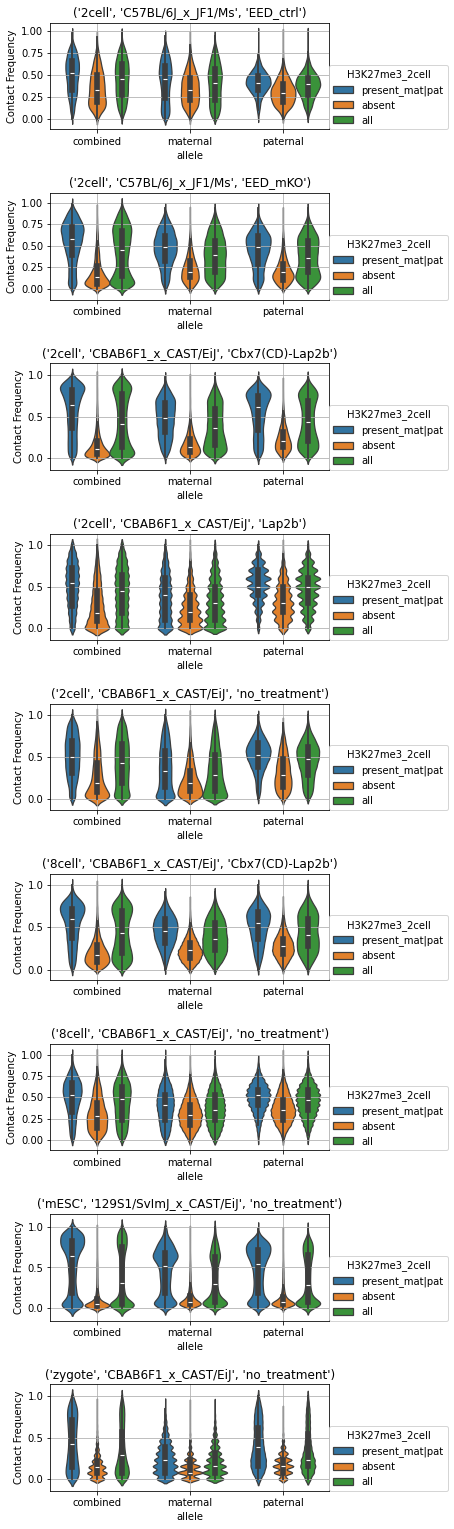

In [27]:
segmentation = 'H3K27me3_2cell'
plot_cf_per_genome_segmentation(segmentation)       
outfn = FIGOUTDIR + 'contact_frquency_distribution.genome_segmented_on_%s.per_condition.violinplot.pdf' % (segmentation)
plt.savefig(outfn, bbox_inches='tight')

__CF in cLADs, ciLADs and fLADs/fiLADs as defined by PericHupkes__

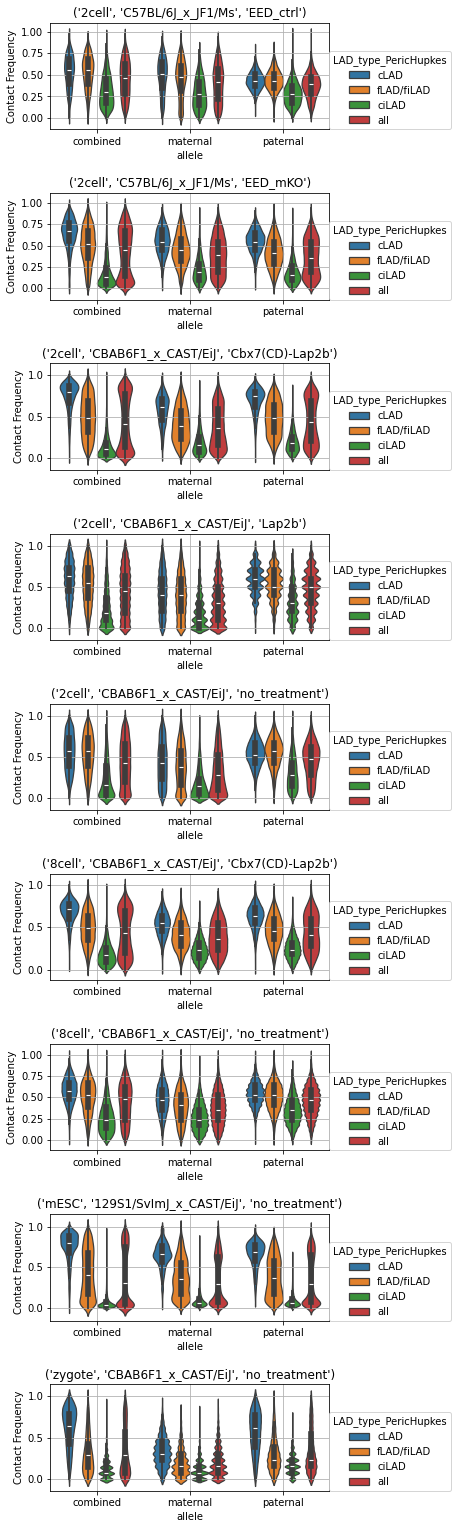

In [28]:
segmentation = 'LAD_type_PericHupkes'
plot_cf_per_genome_segmentation(segmentation)       
outfn = FIGOUTDIR + 'contact_frquency_distribution.genome_segmented_on_%s.per_condition.violinplot.pdf' % (segmentation)
plt.savefig(outfn, bbox_inches='tight')

__CF in genomic regions segmented by the presence of H3K27me3 at the 2-cell stage__

In [29]:
def plot_cf_per_genome_segmentation2(segmentation):
    nrow = len(list(anno.groupby(['stage', 'genotype'])))
    ncol = len(to_plot.loc[to_plot[segmentation]!='invalid',segmentation].unique())
    fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol,nrow*3))
    plt.subplots_adjust(hspace=.6, wspace=1)
    r_counter = -1

    for info, condition_df in to_plot.groupby(['stage', 'genotype']):
        r_counter += 1
        cats = condition_df.loc[condition_df[segmentation]!='invalid',segmentation].sort_values().unique()
        
        for icol, cat in enumerate(cats):
            
            ax = axes[r_counter, icol]
            
            if len(condition_df.treatment.unique()) == 1:
                ax.remove()
                continue
        
            df = condition_df[condition_df[segmentation] == cat].copy()

            order = np.array(treatment_order)
            order = order[np.isin(order, condition_df.treatment.unique())]
            sns.violinplot(
                x=df['allele'], y=df['CF'], 
                hue=df['treatment'], ax=ax,
                palette=color_dict['treatment'], hue_order=order
            )
            ax.legend(loc=(1,0), title='treatment')
            ax.set_title('%s - %s\n%s: %s' % (info[0], info[1], segmentation, cat))
            ax.grid(True)
            ax.set_ylabel('Contact Frequency')

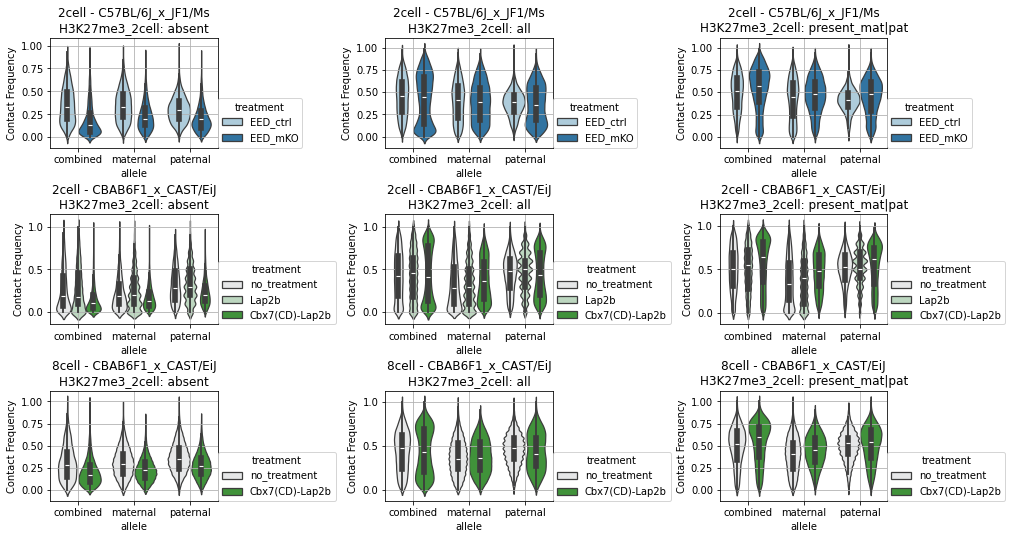

In [30]:
segmentation = 'H3K27me3_2cell'
plot_cf_per_genome_segmentation2(segmentation)       
outfn = FIGOUTDIR + 'contact_frquency_distribution.genome_segmented_on_%s.per_genotype.violinplot.pdf' % (segmentation)
plt.savefig(outfn, bbox_inches='tight')

__CF in cLADs, ciLADs and fLADs/fiLADs as defined by PericHupkes__

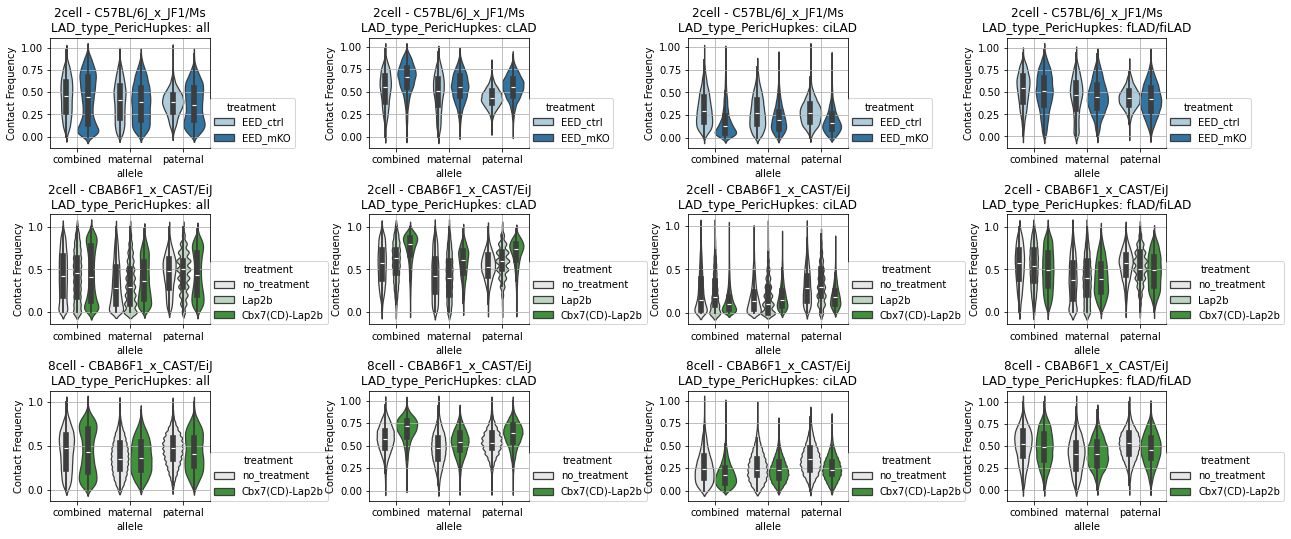

In [31]:
segmentation = 'LAD_type_PericHupkes'
plot_cf_per_genome_segmentation2(segmentation)       
outfn = FIGOUTDIR + 'contact_frquency_distribution.genome_segmented_on_%s.per_genotype.violinplot.pdf' % (segmentation)
plt.savefig(outfn, bbox_inches='tight')